In [54]:
#--- reading polaRates in ROOT format -------------------------------------#
#--- Changes:
#--- 2024-01-31 adding meteo file from CNR
#--- 2024-02-01 verified that all timestamps are in UTC
#--- 2024-02-07 adding median as resampling function (was: mean)

import ROOT
from datetime import datetime,timedelta
import matplotlib.dates as md
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'utc' 

#----------------------------- read_root_file -------------------------------#
def read_root_file(nfile):
    print('Reading ',nfile)
    print('  ...')
    rfile = "/Users/opinazza/cernbox/POLAR/analisi/rootfiles/"+nfile
    f = ROOT.TFile.Open(rfile,"READ")
    tt = f.Get("stats")
    i = 0
    #--preparing the arrays for ALL parameters-----#
    # temp = Sensehat (should be temp1)
    # temp2 = Sensehat
    # temp3 = DS18B20
    # #temp4 = BMO055 (only POLA 1-2, not on 3-4)
    # temp5 = BME280
    # humi = Semsehat
    # pres = Sensehat
    # humi1 = BME280
    # pres1 = BME280
    #
    Nsat_array=[]
    alt_array=[]
    avTot_array=[]
    avTot_matrix=[]
    duration_array=[]
    g_array=[]
    g_matrix=[]
    lat_array=[]
    lon_array=[]
    magnetic_array=[]
    magnetic_matrix=[]
    omega_array=[]
    omega_matrix=[]
    temp5_array=[]
    humi1_array=[]
    pres1_array=[]
    rx1_array=[]
    rx2_array=[]
    pitch_array=[]
    pres_array=[]
    rate_array=[]
    rate4c_array=[]
    rateDir_array=[]
    rateDir_matrix=[[],[]]
    ratePair_array=[]
    ratePair_matrix=[]
    ratePair4c_array=[]
    ratePairAND1_array=[]
    ratePairAND2_array=[]
    ratePair4c_matrix=[]
    ratePairAND1_matrix=[]
    ratePairAND2_matrix=[]
    rateRaw_array=[]
    roll_array=[]
    speed_array=[]
    status_array=[]
    temp_array=[]
    temp2_array=[]
    temp3_array=[]
    tim_array=[]
    yaw_array=[]
    sec_array=[]
    dat_array=[]
    eff_array = []
    eff_matrix = []
    #-- my counters
    excluded = 0
    valid    = 0    
    
    for el in tt: #extracting values from root file
    	Nsat = getattr(el,"Nsat")
    	alt = getattr(el,"alt")
    	avTot_array = getattr(el,"avTot")
    	duration = getattr(el,"duration")
    	eff_array = getattr(el,"eff")
    	g_array = getattr(el,"g")
    	magnetic_array = getattr(el,"magnetic")
    	omega_array = getattr(el,"omega")
    	#parExtra = getattr(el,"parExtra")  #3 elements
    	(temp5,humi1,pres1) = getattr(el,"parExtra")   # <------ pres1
    	#parRates = getattr(el,"parRates")
    	(rx1,rx2) = getattr(el,"parRates")
    	pitch = getattr(el,"pitch")
    	lat = getattr(el,"lat")
    	lon = getattr(el,"lon")
    	pres = getattr(el,"pres")
    	rate = getattr(el,"rate")       # <-----------
    	rate4c = getattr(el,"rate4c")
    	#rateDir = getattr(el,"rateDir")
    	rateDir_array = getattr(el,"rateDir") # 9 elements
    	#ratePair = getattr(el,"ratePair")   #16 elements
    	ratePair_array = getattr(el,"ratePair")   #16 elements
    	ratePair4c_array = getattr(el,"ratePair4c")
    	ratePairAND1_array = getattr(el,"ratePairAND1")
    	ratePairAND2_array = getattr(el,"ratePairAND2")
    	rateRaw = getattr(el,"rateRaw")
    	roll = getattr(el,"roll")
    	speed = getattr(el,"speed")
    	status = getattr(el,"status")
    	temp = getattr(el,"temp")
    	temp2 = getattr(el,"temp2")
    	temp3 = getattr(el,"temp3")
    	tim = getattr(el,"time")
    	yaw = getattr(el,"yaw")
    	#
    	sec=tim+1167609600
    	dat = datetime.utcfromtimestamp(sec).strftime("%Y-%m-%d %H:%M:%S.%f")

        #--- some printouts for check
    	#print(i,[round(r,3) for r in rateDir_array]) #rateDir_array has 9 elements
    	#print (i,tim,temp5,humi1,pres1,rx1,rx2,rate,rateRaw)#px1,px2,px3,,pres,temp,temp2,temp3,status,rate,rateRaw)#rate4c,rateDir,ratePair,ratePair4c,ratePairAND1,ratePairAND2)#,tim,Nsat,alt,lat,lon,avTot,duration,g,magnetic,omega,roll,pitch,yaw)
    	#print (i,dat,rateRaw,temp5,humi1,pres1)#px1,px2,px3,,pres,temp,temp2,temp3,status,rate,rateRaw)#rate4c,rateDir,ratePair,ratePair4c,ratePairAND1,ratePairAND2)#,tim,Nsat,alt,lat,lon,avTot,duration,g,magnetic,omega,roll,pitch,yaw)
    	#i = i+1
    	#if (i==1000):
    	#	break
    	
    	rate = float(rate)
    	rx1=float(rx1)
    	rx2=float(rx2)
    	rateRaw=float(rateRaw)
    	pres=float(pres)
    	pres1=float(pres1)
    	#print(i,rate,rx1,rx2,rateRaw,pres,pres1)
        
    	# applying pressure correction to rates, with pres or pres1 if pres not available
    	if (700.0 <= pres <= 1100.):    # pressure correction! Pressure1 not available for P4 [autumn 2022 - now january 2023]
           rate=rate/math.exp(-0.002*(pres-1000))
    	elif (700.0 <= pres1 <= 1100.): # pressure correction with the second sensor
           rate=rate/math.exp(-0.002*(pres1-1000))
    	else:
           rate=np.nan
           continue

    	#------- selecting acceptable rates -- implementing cuts ---#
        # criteria:
        #   - status==0
        #   - max difference allowed between rates (dd=3, can be changed)
        #   - rate> 20 Hz
    	dd = 3 #max difference allowed between rates
    	if (int(status)>0):
           rate = np.nan
           continue
    	elif (int(status)==0) and ((abs(rate-rx1)>dd or abs(rate-rx2)>dd or abs(rate-rateRaw)>dd or abs(rateRaw-rx1)>dd or abs(rateRaw-rx2)>dd or abs(rx1-rx2)>dd)  ):
           #print(line)
           rate = np.nan
           excluded = excluded+1
           continue
    	elif (rate<10):    # <------- excluding very very low rates
           rate = np.nan
           excluded = excluded+1
           continue
    	else:
           valid = valid+1


    	#---- appending values to the arrays ----#
    	Nsat_array.append(int(Nsat))
    	alt_array.append(float(alt))
    	avTot_matrix.append(avTot_array)
    	duration_array.append(float(duration))
    	g_matrix.append(g_array)
    	lat_array.append(float(lat))
    	lon_array.append(float(lon))
    	magnetic_matrix.append(magnetic_array)
    	omega_matrix.append(omega_array)
    	temp5_array.append(float(temp5))
    	humi1_array.append(float(humi1))
    	pres1_array.append(float(pres1))
    	rx1_array.append(float(rx1))
    	rx2_array.append(float(rx2))
    	pitch_array.append(float(pitch))
    	pres_array.append(float(pres))
    	rate_array.append(float(rate))
    	rate4c_array.append(float(rate4c))
    	rateDir_matrix.append(rateDir_array)
    	ratePair_matrix.append(ratePair_array)
    	ratePair4c_matrix.append(ratePair4c_array)
    	ratePairAND1_matrix.append(ratePairAND1_array)
    	ratePairAND2_matrix.append(ratePairAND2_array)
    	rateRaw_array.append(float(rateRaw))
    	roll_array.append(float(roll))
    	speed_array.append(float(speed))
    	status_array.append(int(status))
    	temp_array.append(float(temp))
    	temp2_array.append(float(temp2))
    	temp3_array.append(float(temp3))
    	tim_array.append(int(tim))
    	yaw_array.append(float(yaw))
    	sec_array.append(int(sec))
    	dat_array.append(dat)
    	eff_matrix.append(eff_array)
    
    #-- building an array of datetime from epoch
    dates=[datetime.utcfromtimestamp(float(ts)) for ts in sec_array]
    
    #------- building the dataframe -----#
    #-- returning all env params ---#
    pdf=pandas.DataFrame( {'datetimep':dates,'rate':rate_array,'pres':pres_array,'pres1':pres1_array,'temp':temp_array,'temp2':temp2_array,'temp3':temp3_array,'temp5':temp5_array,'humi1':humi1_array}, columns=['datetimep','rate','pres','pres1','temp','temp2','temp3','temp5','humi1'])
    #-- returning only rate,pres,temp
    #pdf=pandas.DataFrame( {'datetimep':dates,'rate':rate_array,'pres':pres_array,'temp':temp_array}, columns=['datetimep','rate','pres','temp'])

    #--convert the dataframe index to a datetime index
    pdf['datetime'] = pandas.to_datetime(pdf['datetimep'])
    pdf = pdf.set_index('datetime')
    pdf.drop(['datetimep'],axis=1,inplace=True)
    
    #pdf.info()
    #print(pdf)
    totalv = valid+excluded
    print('  Total values =',totalv)
    print('  ..valid values =',valid,' (',round(valid*100/totalv,1),'%)')
    print('  ..excluded values =',excluded,' (',round(excluded*100/totalv,1),'%)')
    print('  Finished reading ',nfile)
    return pdf
#------------------------ end read_root_file -------------------------------------#


#------------- removing NaN from arrays --------------------#
#(was needed while analyzing periodograms and matrix)
def removing_nan(t1,r1):
    #ss=[]
    rr=[]
    tt=np.zeros((0), dtype='datetime64[s]')
    #mm=[]
    #er=[]

    removedNaN=0
    for i in range(0,len(r1)):
        #print(i,r1[i],np.isnan(r1[i]))
        #if (np.isnan(r1[i]) or np.isnan(er1[i])):
        if (np.isnan(r1[i])):
            #skipping NaN value
            #print('Skipping NaN:  i=',i,', r1=',r1[i])
            removedNaN=removedNaN+1
        else:
            #print('Keeping value:  i=',i,', r1=',r1[i],', t1=',t1[i])
            #ss=np.append(ss,s1[i])
            tt=np.append(tt,t1[i])
            #mm=np.append(mm,m1[i])
            rr=np.append(rr,r1[i])
            #er=np.append(er,er1[i])
    print(' -- rate values = ',len(r1))
    print(' -- >> removed NaN values = ',removedNaN)
    print(' -- valid rate values = ',len(rr))
    return tt,rr

#----------- ----------------------------- -----------#



#----------- functions to convert datetime to the MJD ----------#
# (needed by altromonical python modules like periodogram etc.)
def datetime_to_mjd(date):
    year=date.year
    month=date.month
    ho=date.hour
    mi = date.minute
    se=date.second
    ms=date.microsecond
    days = se+(ms/1.e6)
    days = mi + (days / 60.)
    days = ho + (days / 60.)
    days = days / 24.

    days = date.day +days
    if month == 1 or month == 2:
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month
    
    # this checks where we are in relation to October 15, 1582, the beginning
    # of the Gregorian calendar.
    if ((year < 1582) or
        (year == 1582 and month < 10) or
        (year == 1582 and month == 10 and days < 15)):
        # before start of Gregorian calendar
        B = 0
    else:
        # after start of Gregorian calendar
        A = math.trunc(yearp / 100.)
        B = 2 - A + math.trunc(A / 4.)
        
    if yearp < 0:
        C = math.trunc((365.25 * yearp) - 0.75)
    else:
        C = math.trunc(365.25 * yearp)
        
    D = math.trunc(30.6001 * (monthp + 1))
    
    jd = B + C + D + days + 1720994.5
    mjd = jd-2400000.5
    
    return mjd




print("UTC   time = ",datetime.utcnow())
print("local time = ",datetime.now())
print('Done.')

UTC   time =  2024-02-10 12:47:31.178465
local time =  2024-02-10 13:47:31.178638
Done.


In [55]:
pdf1 = read_root_file("outPOLA-01.root")
pdf3 = read_root_file("outPOLA-03.root")
pdf4 = read_root_file("outPOLA-04.root")
print('Done.')

Reading  outPOLA-01.root
  ...
  Total values = 1518872
  ..valid values = 1249724  ( 82.3 %)
  ..excluded values = 269148  ( 17.7 %)
  Finished reading  outPOLA-01.root
Reading  outPOLA-03.root
  ...
  Total values = 2113238
  ..valid values = 1751765  ( 82.9 %)
  ..excluded values = 361473  ( 17.1 %)
  Finished reading  outPOLA-03.root
Reading  outPOLA-04.root
  ...
  Total values = 1601741
  ..valid values = 1555299  ( 97.1 %)
  ..excluded values = 46442  ( 2.9 %)
  Finished reading  outPOLA-04.root
Done.


In [57]:
#------------------- preparing arrays for plots ---------------#

#resampling = '0' #    <------  no resample, rate per ~minute, WARNING: can be very slow
#resampling = '30min'
resampling = '1d'
#resampling = '1h'
if (resampling=='0'):
    print('No resampling, using rates per minute')
    #no resampling
    p1df_resampled=pdf1
    p3df_resampled=pdf3
    p4df_resampled=pdf4

else:
    print('Starting resampling arrays : rate per ',resampling)
    p1df_resampled_mean=pdf1.resample(resampling).mean()
    p3df_resampled_mean=pdf3.resample(resampling).mean()
    p4df_resampled_mean=pdf4.resample(resampling).mean()
    p1df_resampled=pdf1.resample(resampling).median()
    p3df_resampled=pdf3.resample(resampling).median()
    p4df_resampled=pdf4.resample(resampling).median()

#original rates
ro1 = pdf1['rate'].values
to1 = np.array(pdf1.index.to_pydatetime(), dtype=np.datetime64)
ro3 = pdf3['rate'].values
to3 = np.array(pdf3.index.to_pydatetime(), dtype=np.datetime64)
ro4 = pdf4['rate'].values
to4 = np.array(pdf4.index.to_pydatetime(), dtype=np.datetime64)

#resampled rates (with mean and median)
print('.... resampling arrays for POLA1')
#print('.... rate P1')
ra1mean = p1df_resampled_mean['rate'].values # <--- only used for comparison with median resampling
ra1 = p1df_resampled['rate'].values
#print('.... time P1')
ta1 = np.array(p1df_resampled.index.to_pydatetime(), dtype=np.datetime64)
#print('.... remove nan')  #----- removing nan not needed anymore, and very slow
#t1,r1 = removing_nan(ta1,ra1)
#resampled with median
t1=ta1
r1=ra1
#print('.... s_time P1')
s1 = (t1.astype(np.int64))/1e6

print('.... resampling arrays for POLA3')
#print('.... rate P3')
ra3mean = p3df_resampled_mean['rate'].values # <--- only used for comparison with median resampling
ra3 = p3df_resampled['rate'].values
#print('.... time P3')
ta3 = np.array(p3df_resampled.index.to_pydatetime(), dtype=np.datetime64)
#t3,r3 = removing_nan(ta3,ra3) #-- avoiding inserting nan from read_root_routine
t3=ta3
r3=ra3
#print('.... s_time P3')
s3 = (t3.astype(np.int64))/1e6

print('.... resampling arrays for POLA4')
#print('.... rate P4')
ra4mean = p4df_resampled_mean['rate'].values # <--- only used for comparison with median resampling
ra4 = p4df_resampled['rate'].values
#print('.... time P4')
ta4 = np.array(p4df_resampled.index.to_pydatetime(), dtype=np.datetime64)
#t4,r4 = removing_nan(ta4,ra4)
t4=ta4
r4=ra4
#print('.... s_time P4')
s4 = (t4.astype(np.int64))/1e6


#--- defining MJD times (needed by astronomical pymodules like periodograms etc.)
build_MJD=True
if build_MJD:
    #from datetime import datetime  #already loaded above
    m1 = np.array([])
    m3 = np.array([])
    m4 = np.array([])
    print('.... MJD time P1')
    for i in range(0,len(s1)):
        dt=datetime.fromtimestamp(s1[i])
        mjdop = datetime_to_mjd(dt)
        m1=np.append(m1,mjdop)
    print('.... MJD time P3')
    for i in range(0,len(s3)):
        dt=datetime.fromtimestamp(s3[i])
        mjdop = datetime_to_mjd(dt)
        m3=np.append(m3,mjdop)
    print('.... MJD time P4')
    for i in range(0,len(s4)):
        dt=datetime.fromtimestamp(s4[i])
        mjdop = datetime_to_mjd(dt)
    m4=np.append(m4,mjdop)

print('Done.')

Starting resampling arrays : rate per  1d
.... resampling arrays for POLA1
.... resampling arrays for POLA3
.... resampling arrays for POLA4
.... MJD time P1
.... MJD time P3
.... MJD time P4
Done.


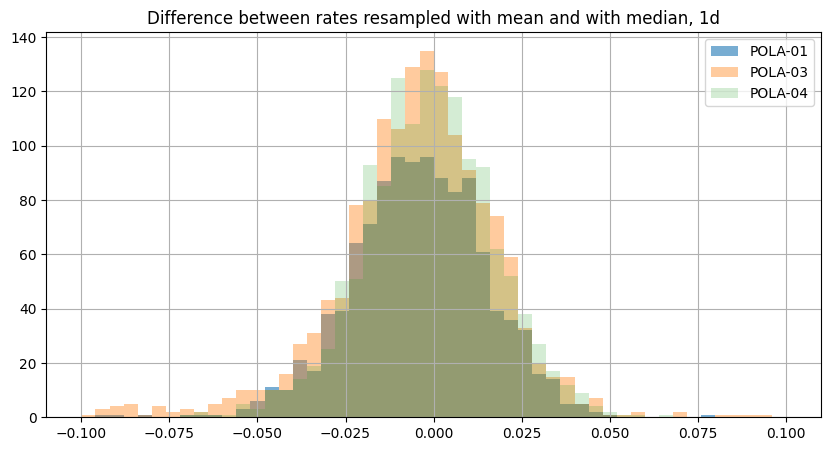

In [69]:
#--- check the difference between resampled with mean and with median
#
# we have p1df_resampled_mean and p1df_resampled (median)
#
#
from pandas import Series
from pandas.plotting import autocorrelation_plot

#vect=p1df_resampled['rate']
#vect=p1df_resampled_mean['rate']-vect
#series = Series(vect)
#print(series.describe())
#plt.rcParams["figure.figsize"] = (10,5)
#series.hist(alpha=0.5,bins=100, range=[-0.1,0.1])
#tit='POLA-01: difference between rate resampled with mean and with median, '+resampling
#plt.title(tit)

#vect=p3df_resampled['rate']
#vect=p3df_resampled_mean['rate']-vect
#series = Series(vect)
#print(series.describe())
#plt.rcParams["figure.figsize"] = (10,5)
#series.hist(alpha=0.5,bins=100, range=[-0.1,0.1])
#tit='POLA-03: difference between rate resampled with mean and with median, '+resampling
#plt.title(tit)

#vect=p4df_resampled['rate']
#vect=p4df_resampled_mean['rate']-vect
#series = Series(vect)
#print(series.describe())
#plt.rcParams["figure.figsize"] = (10,5)
#series.hist(alpha=0.5,bins=100, range=[-0.1,0.1])
#tit='POLA-04: difference between rate resampled with mean and with median, '+resampling
#plt.title(tit)

#Three together
plt.rcParams["figure.figsize"] = (10,5)
vect=p1df_resampled['rate']
vect=p1df_resampled_mean['rate']-vect
series = Series(vect)
series.hist(alpha=0.6,bins=50, range=[-0.1,0.1],label='POLA-01')
vect=p3df_resampled['rate']
vect=p3df_resampled_mean['rate']-vect
series = Series(vect)
series.hist(alpha=0.4,bins=50, range=[-0.1,0.1],label='POLA-03')
vect=p4df_resampled['rate']
vect=p4df_resampled_mean['rate']-vect
series = Series(vect)
series.hist(alpha=0.2,bins=50, range=[-0.1,0.1],label='POLA-04')
tit='Difference between rates resampled with mean and with median, '+resampling
plt.title(tit)
plt.legend(loc='upper right')


Done with rate plot.


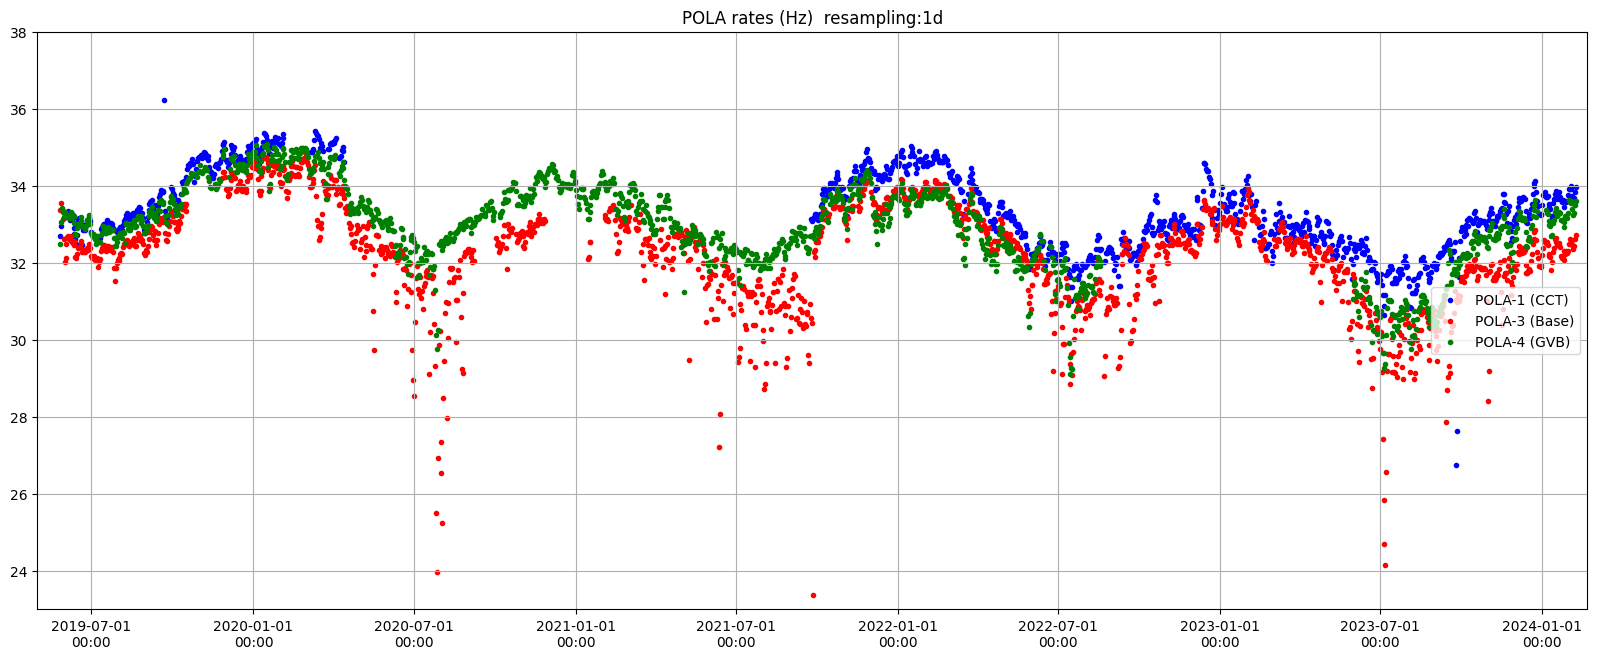

In [200]:
#--------- now we can plot POLA rates - rates resampled over 1day
plt.rcParams["figure.figsize"] = (20,7.5)
tit = "POLA rates (Hz) "
if resampling!='0':
    tit = tit+' resampling:'+resampling
ax=plt.gca()
plt.title(tit)
#ax.set_ylim(27,36)  #--- OK if there is resampling
ax.set_ylim(23,38)

plt.scatter(t1,r1,color='blue',marker=".",label="POLA-1 (CCT)")
plt.scatter(t3,r3,color='red',marker=".",label="POLA-3 (Base)")
plt.scatter(t4,r4,color='green',marker='.',label="POLA-4 (GVB)")
plt.grid(visible=True)
plt.legend(loc='center right')
plt.xlim(datetime(2019,5,1,0,0),datetime(2024,2,20,23,59))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
ax.xaxis.set_major_formatter(xfmt)


print('Done with rate plot.')

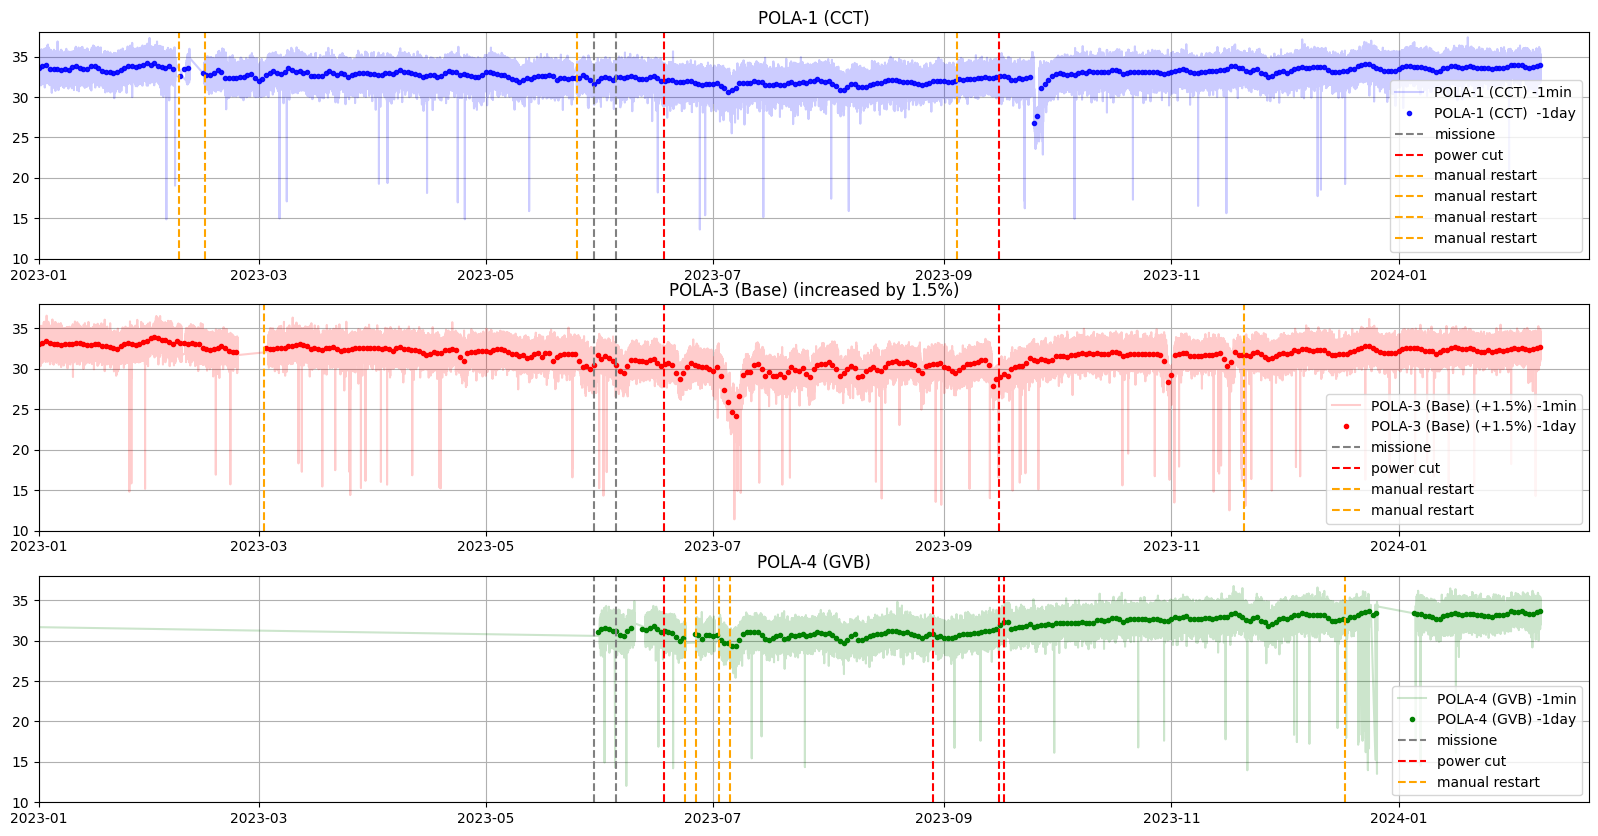

In [78]:
#-------------- plotting 3 subplots in 2023, with vertical bars corresponding to interventions -----------------------#
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(3,1)
axs[0].plot(to1,ro1, alpha=0.2,color='blue',label="POLA-1 (CCT) -1min")
axs[0].plot(t1,r1, '.', alpha=0.9,color='blue',label="POLA-1 (CCT)  -1day")
axs[0].set_title('POLA-1 (CCT)')
axs[1].plot(to3,ro3, alpha=0.2, color='red',label="POLA-3 (Base) (+1.5%) -1min")
axs[1].plot(t3,r3, '.', color='red',label="POLA-3 (Base) (+1.5%) -1day")
axs[1].set_title('POLA-3 (Base) (increased by 1.5%)')
axs[2].plot(to4,ro4,  alpha=0.2, color='green',label="POLA-4 (GVB) -1min")
axs[2].plot(t4,r4, '.', color='green',label="POLA-4 (GVB) -1day")
axs[2].set_title('POLA-4 (GVB)')
xfmt = md.DateFormatter('%Y-%m')
y0=10
y1=38
for i in range (0,3):
    axs[i].xaxis.set_major_formatter(xfmt)
    #axs[i].set(xlim=(datetime(2023,5,1,0,0),datetime(2024,1,1,23,59)),ylim=(y0,y1))
    axs[i].set(xlim=(datetime(2023,1,1,0,0),datetime(2024,2,20,23,59)),ylim=(y0,y1))
    axs[i].grid()
    axs[i].vlines(x=datetime(2023,5,30,0,0),ymin=y0,ymax=y1,colors='grey',linestyles='dashed',label='missione')
    axs[i].vlines(x=datetime(2023,6,5,0,0),ymin=y0,ymax=y1,colors='grey',linestyles='dashed')#,label='missione')
    axs[i].vlines(x=datetime(2023,6,17,21,0),ymin=y0,ymax=y1,colors='red',linestyles='dashed',label='power cut')
    axs[i].vlines(x=datetime(2023,9,15,19,30),ymin=y0,ymax=y1,colors='red',linestyles='dashed')#,label='power cut')
#--- power interruption\
axs[2].vlines(x=datetime(2023,8,29,0,0),ymin=y0,ymax=y1,colors='red',linestyles='dashed')#,label='power failure a GVB')
axs[2].vlines(x=datetime(2023,9,16,23,30),ymin=y0,ymax=y1,colors='red',linestyles='dashed')#,label='power cut a GVB')
#-- manual interventions
axs[0].vlines(x=datetime(2023,2,7,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed',label='manual restart')
axs[0].vlines(x=datetime(2023,2,14,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed',label='manual restart')
axs[0].vlines(x=datetime(2023,9,4,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed',label='manual restart')
axs[0].vlines(x=datetime(2023,5,25,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed',label='manual restart')
axs[1].vlines(x=datetime(2023,11,20,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed',label='manual restart')
axs[1].vlines(x=datetime(2023,3,2,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed',label='manual restart')
axs[2].vlines(x=datetime(2023,6,23,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed',label='manual restart')
axs[2].vlines(x=datetime(2023,6,26,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed')#,label='manual restart')
axs[2].vlines(x=datetime(2023,7,2,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed')#,label='manual restart')
axs[2].vlines(x=datetime(2023,7,5,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed')#,label='manual restart')
axs[2].vlines(x=datetime(2023,12,17,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed')#,label='manual restart')
#axs[2].vlines(x=datetime(2024,1,5,12,30),ymin=y0,ymax=y1,colors='orange',linestyles='dashed',label='manual restart')
for i in range (0,3):
    axs[i].legend(loc='lower right')



In [203]:
#------ when we do resampling='0' we might want to show a resampled curve together 
#       otherwise skip this part
#--- moving_average is available in numpy.

resampling_with_median=True
resampling_with_moving_average=False
new_resampling='15d'

#------------------- preparing arrays for plots ---------------#
print('Data are resampled by:',resampling)
print('Adding array with resampling:',new_resampling)

if resampling_with_moving_average:
    #---- resampling with moving_average, OK for smooth plots
    import numpy as np
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    window=7 # 7days=1week
    print('Resampling with moving_average:',window)
    
    rr1=moving_average(r1,window)
    ss1=moving_average(s1,window)
    #mm1=moving_average(m1,window)
    #tt3=moving_average(t3,window)
    rr3=moving_average(r3,window)
    ss3=moving_average(s3,window)
    #mm3=moving_average(m3,window)
    #tt4=moving_average(t4,window)
    rr4=moving_average(r4,window)
    ss4=moving_average(s4,window)
    #mm4=moving_average(m4,window)
    #--rebuilding time arrays (time data cannot be averaged/convolved)
    tt1=[]
    for i in range(0,len(ss1)):
        dt=datetime.utcfromtimestamp(ss1[i])
        tt1.append(dt)
    tt3=[]
    for i in range(0,len(ss3)):
        dt=datetime.utcfromtimestamp(ss3[i])
        tt3.append(dt)
    tt4=[]
    for i in range(0,len(ss4)):
        dt=datetime.utcfromtimestamp(ss4[i])
        tt4.append(dt)


if resampling_with_median:
    p1df_resampled_new=pdf1.resample(new_resampling).median()
    p3df_resampled_new=pdf3.resample(new_resampling).median()
    p4df_resampled_new=pdf4.resample(new_resampling).median()
    r1n = p1df_resampled_new['rate'].values
    t1n = np.array(p1df_resampled_new.index.to_pydatetime(), dtype=np.datetime64)
    s1n = (t1.astype(np.int64))/1e6
    r3n = p3df_resampled_new['rate'].values
    t3n = np.array(p3df_resampled_new.index.to_pydatetime(), dtype=np.datetime64)
    s3n = (t3.astype(np.int64))/1e6
    r4n = p4df_resampled_new['rate'].values
    t4n = np.array(p4df_resampled_new.index.to_pydatetime(), dtype=np.datetime64)
    s4n = (t4.astype(np.int64))/1e6
    # computing MJD arrays as well
    m1n = np.array([])
    m3n = np.array([])
    m4n = np.array([])
    for i in range(0,len(s1n)):
        dt=datetime.fromtimestamp(s1n[i])
        mjdop = datetime_to_mjd(dt)
        m1n=np.append(m1n,mjdop)
    for i in range(0,len(s3n)):
        dt=datetime.fromtimestamp(s3n[i])
        mjdop = datetime_to_mjd(dt)
        m3n=np.append(m3n,mjdop)
    for i in range(0,len(s4n)):
        dt=datetime.fromtimestamp(s4n[i])
        mjdop = datetime_to_mjd(dt)
    m4n=np.append(m4n,mjdop)

print('POLA-01:',len(r1))
print('POLA-03:',len(r3))
print('POLA-04:',len(r4))

print('POLA-01:',len(r1n))
print('POLA-03:',len(r3n))
print('POLA-04:',len(r4n))
print('Done.')

Data are resampled by: 1d
Adding array with resampling: 15d
POLA-01: 1719
POLA-03: 1719
POLA-04: 1719
POLA-01: 115
POLA-03: 115
POLA-04: 115
Done.


Done with rate plot.


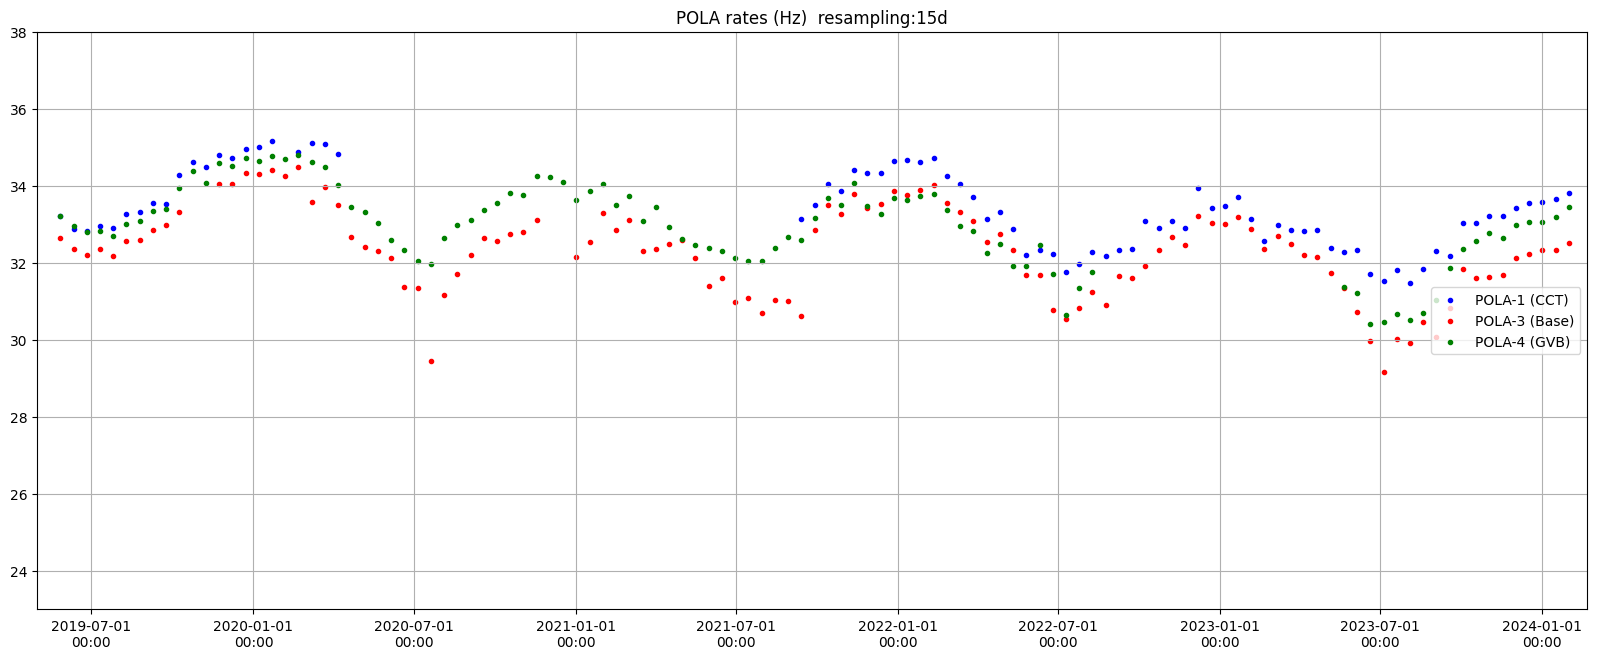

In [201]:
#--------- now we can plot POLA rates - rates resampled over 15days
plt.rcParams["figure.figsize"] = (20,7.5)
tit = "POLA rates (Hz) "
tit = tit+' resampling:'+new_resampling
ax=plt.gca()
plt.title(tit)
#ax.set_ylim(27,36)  #--- OK if there is resampling
ax.set_ylim(23,38)

plt.scatter(t1n,r1n,color='blue',marker=".",label="POLA-1 (CCT)")
plt.scatter(t3n,r3n,color='red',marker=".",label="POLA-3 (Base)")
plt.scatter(t4n,r4n,color='green',marker='.',label="POLA-4 (GVB)")
plt.grid(visible=True)
plt.legend(loc='center right')
plt.xlim(datetime(2019,5,1,0,0),datetime(2024,2,20,23,59))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
ax.xaxis.set_major_formatter(xfmt)


print('Done with rate plot.')

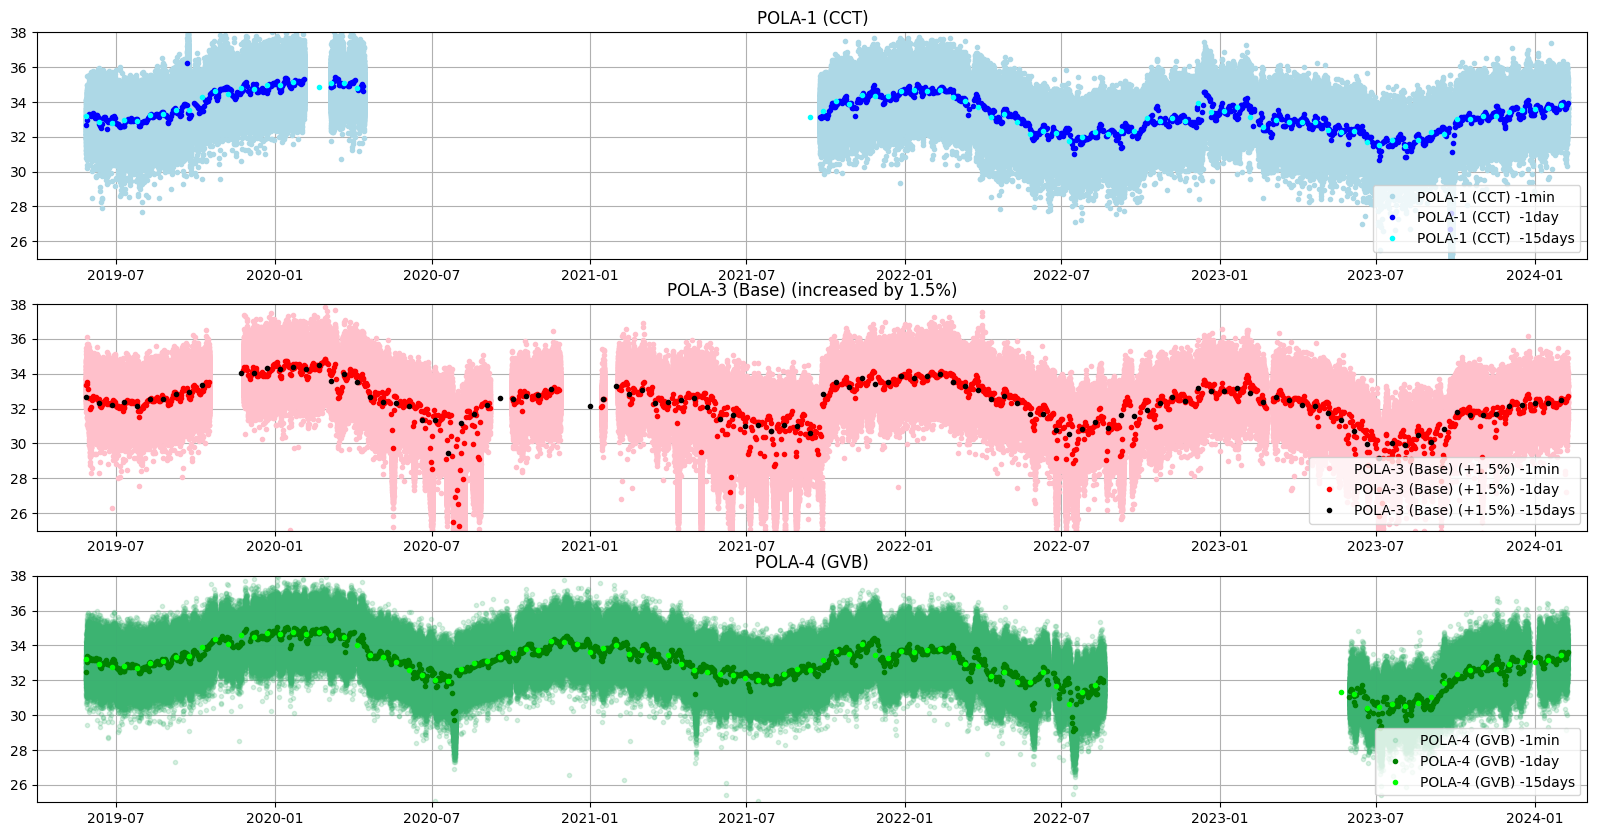

In [108]:
#-------------- plotting 3 subplots with original and resampled datasets -----------------------#
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(3,1)
#axs[0].plot(to1,ro1,'.', alpha=0.1,color='darkblue',label="POLA-1 (CCT) -1min")
#axs[0].plot(t1,r1, '.', alpha=0.7,color='blue',label="POLA-1 (CCT)  -1day")
#axs[0].plot(t1n,r1n, '.', alpha=1,color='lightblue',label="POLA-1 (CCT)  -15days")
axs[0].plot(to1,ro1,'.', alpha=1,color='lightblue',label="POLA-1 (CCT) -1min")
axs[0].plot(t1,r1, '.', alpha=1,color='blue',label="POLA-1 (CCT)  -1day")
axs[0].plot(t1n,r1n, '.', alpha=1,color='cyan',label="POLA-1 (CCT)  -15days")
axs[0].set_title('POLA-1 (CCT)')
axs[1].plot(to3,ro3, '.', color='pink',label="POLA-3 (Base) (+1.5%) -1min")
axs[1].plot(t3,r3, '.', color='red',label="POLA-3 (Base) (+1.5%) -1day")
axs[1].plot(t3n,r3n,'.',color='black',label="POLA-3 (Base) (+1.5%) -15days")
axs[1].set_title('POLA-3 (Base) (increased by 1.5%)')
axs[2].plot(to4,ro4,'.', alpha=0.2, color='mediumseagreen',label="POLA-4 (GVB) -1min")
axs[2].plot(t4,r4, '.', color='green',label="POLA-4 (GVB) -1day")
axs[2].plot(t4n,r4n, '.', color='lime',label="POLA-4 (GVB) -15days")
axs[2].set_title('POLA-4 (GVB)')
xfmt = md.DateFormatter('%Y-%m')
y0=25
y1=38

for i in range (0,3):
    axs[i].xaxis.set_major_formatter(xfmt)
    axs[i].set(xlim=(datetime(2019,4,1,0,0),datetime(2024,3,1,23,59)),ylim=(y0,y1))
    axs[i].grid()
    axs[i].legend(loc='lower right')



In [140]:
#--- reading meteo file (CNR data, CCT 2m) ---------------------#
#
#
def read_meteo(fname):
    print("Reading METEO data")
    #fname='/Users/opinazza/cernbox/POLAR/analisi/meteo/meteo_NYA.txt'
    #--old syntax to parse dates
    #mydateparser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    #mdf = pandas.read_csv(fname, delim_whitespace=True, names=['date','time','t','rh','p'], comment='#', parse_dates={'datetime1':[0,1]}, date_parser=mydateparser,na_values=[-999999,1.9698e+07,-4.98893e+07,-1.59977e+07])
    date_format = "%Y-%m-%d %H:%M:%S"
    mdf = pandas.read_csv(fname, delim_whitespace=True, names=['date','time','t','rh','p'], comment='#', parse_dates={'datetime1':[0,1]}, date_format=date_format,na_values=[-999999,1.9698e+07,-4.98893e+07,-1.59977e+07])

    #--convert the dataframe index to a datetime index
    mdf['datetime'] = pandas.to_datetime(mdf['datetime1'],utc=True)
    mdf = mdf.set_index('datetime')
    mdf.drop(['datetime1'],axis=1,inplace=True)
    #--options to truncate series
    #mdf_30min=mdf.resample('30min').mean()
    #mdf_a = mdf_30min.truncate(before='2019-06-01', after='2021-11-30')
    return mdf

mdf=read_meteo('/Users/opinazza/cernbox/POLAR/analisi/meteo/meteo_NYA.txt')
print(mdf)
mdf.info()

temp_CCT = mdf['t'].values
pres_CCT = mdf['p'].values
humi_CCT = mdf['rh'].values
#time_CCT = np.array(mdf.index.to_pydatetime(), dtype=np.datetime64)
##datetime64 raising a warning, but it seems it is not needed..
time_CCT = np.array(mdf.index.to_pydatetime())


Reading METEO data
                                t       rh         p
datetime                                            
2019-05-01 00:01:00+00:00 -9.0009  57.8024  1012.000
2019-05-01 00:02:00+00:00 -9.0009  58.9724  1012.000
2019-05-01 00:03:00+00:00 -9.0009  58.4824  1012.000
2019-05-01 00:04:00+00:00 -8.9909  57.5024  1012.000
2019-05-01 00:05:00+00:00 -8.9809  58.3824  1012.000
...                           ...      ...       ...
2023-12-31 23:56:00+00:00 -1.5374  57.8550   997.955
2023-12-31 23:57:00+00:00 -1.4914  58.0250   997.911
2023-12-31 23:58:00+00:00 -1.4904  58.0800   997.907
2023-12-31 23:59:00+00:00 -1.5304  58.2450   997.899
2024-01-01 00:00:00+00:00 -1.5854  58.4300   997.942

[2466720 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2466720 entries, 2019-05-01 00:01:00+00:00 to 2024-01-01 00:00:00+00:00
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   t       float64
 1   rh      float64
 2   p       float64
dt

In [145]:
#------------- preparing environmental data from polarRates ----------#
# values: r4,pres4,pres14,temp4,temp42,temp43,temp45
# time: t4
# original: ro4,to4,  preo4,preo41,temo4,temo42,temo43,temo45
# same for pola-3 pola-1

preo1  = pdf1['pres'].values
preo11 = pdf1['pres1'].values
temo1  = pdf1['temp'].values
temo12 = pdf1['temp2'].values
temo13 = pdf1['temp3'].values
temo15 = pdf1['temp5'].values

preo3  = pdf3['pres'].values
preo31 = pdf3['pres1'].values
temo3  = pdf3['temp'].values
temo32 = pdf3['temp2'].values
temo33 = pdf3['temp3'].values
temo35 = pdf3['temp5'].values

preo4  = pdf4['pres'].values
preo41 = pdf4['pres1'].values
temo4  = pdf4['temp'].values
temo42 = pdf4['temp2'].values
temo43 = pdf4['temp3'].values
temo45 = pdf4['temp5'].values

# fixing some temperatures out-of-range
tmin=-40
for i in range(0,len(temo1)):
    if (temo1[i]<tmin):
        temo1[i]=float('nan')
    if (temo12[i]<tmin):
        temo12[i]=float('nan')
    if (temo13[i]<tmin):
        temo13[i]=float('nan')
    if (temo15[i]<tmin):
        temo15[i]=float('nan')
tmin=-40
for i in range(0,len(temo3)):
    if (temo3[i]<tmin):
        temo3[i]=float('nan')
    if (temo32[i]<tmin):
        temo32[i]=float('nan')
    if (temo33[i]<tmin):
        temo33[i]=float('nan')
    if (temo35[i]<tmin):
        temo35[i]=float('nan')
tmin=-40
for i in range(0,len(temo4)):
    if (temo4[i]<tmin):
        temo4[i]=float('nan')
    if (temo42[i]<tmin):
        temo42[i]=float('nan')
    if (temo43[i]<tmin):
        temo43[i]=float('nan')
    if (temo45[i]<tmin):
        temo45[i]=float('nan')


(1000.0, 1050.0)

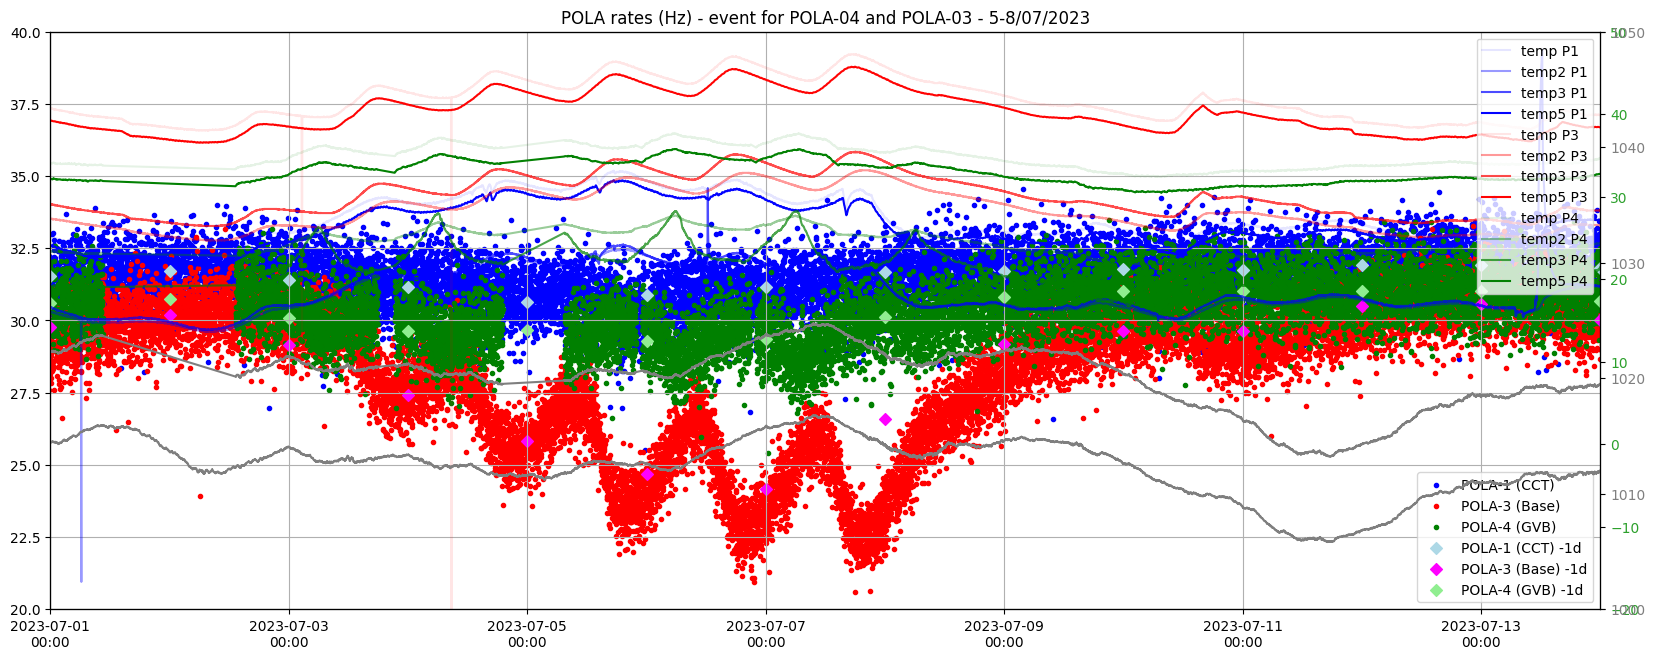

In [146]:
#------------- what happened on 10/7/2023 (mainly to POLA-4) -------------#
#
# visible with ORIGINAL data (or very low resampling)
# 

plt.rcParams["figure.figsize"] = (20,7.5)
ax=plt.gca()
plt.title("POLA rates (Hz) - event for POLA-04 and POLA-03 - 5-8/07/2023")
#ax.set_ylim(27,36)  #--- OK if there is resampling
ax.set_ylim(20,40)

plt.scatter(to1,ro1,color='blue',marker=".",label="POLA-1 (CCT)")
plt.scatter(to3,ro3,color='red',marker=".",label="POLA-3 (Base)")
plt.scatter(to4,ro4,color='green',marker='.',label="POLA-4 (GVB)")
plt.scatter(t1,r1,color='lightblue',marker="D",label="POLA-1 (CCT) -1d")
plt.scatter(t3,r3,color='magenta',marker="D",label="POLA-3 (Base) -1d")
plt.scatter(t4,r4,color='lightgreen',marker='D',label="POLA-4 (GVB) -1d")
plt.grid(visible=True)
plt.legend(loc='lower right')
plt.xlim(datetime(2023,7,1,0,0),datetime(2023,7,13,23,59))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
ax.xaxis.set_major_formatter(xfmt)

ax2 = ax.twinx()
color4 = 'tab:blue'
#ax2.set_ylabel('env', color=color)
ax2.plot(to1, temo1,  color=('blue', 0.1), label="temp P1")
ax2.plot(to1, temo12, color=('blue', 0.4), label="temp2 P1")
ax2.plot(to1, temo13, color=('blue', 0.7), label="temp3 P1")
ax2.plot(to1, temo15, color=('blue', 0.99), label="temp5 P1")
plt.legend(loc='upper right')

color3 = 'tab:red'
ax2.plot(to3, temo3,  color=('red', 0.1), label="temp P3")
ax2.plot(to3, temo32, color=('red', 0.4), label="temp2 P3")
ax2.plot(to3, temo33, color=('red', 0.7), label="temp3 P3")
ax2.plot(to3, temo35, color=('red', 0.99), label="temp5 P3")
plt.legend(loc='upper right')

color4 = 'tab:green'
#ax2.set_ylabel('env', color=color)
ax2.plot(to4, temo4,  color=('green', 0.1), label="temp P4")
ax2.plot(to4, temo42, color=('green', 0.4), label="temp2 P4")
ax2.plot(to4, temo43, color=('green', 0.7), label="temp3 P4")
ax2.plot(to4, temo45, color=('green', 0.99), label="temp5 P4")
plt.legend(loc='upper right')

ax2.tick_params(axis='y', labelcolor=color4)
ax2.set_ylim(-20,50)

ax3 = ax.twinx()
color = 'tab:grey'
ax3.plot(to4, preo4, color=color)
ax3.plot(time_CCT, pres_CCT, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(1000,1050)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped


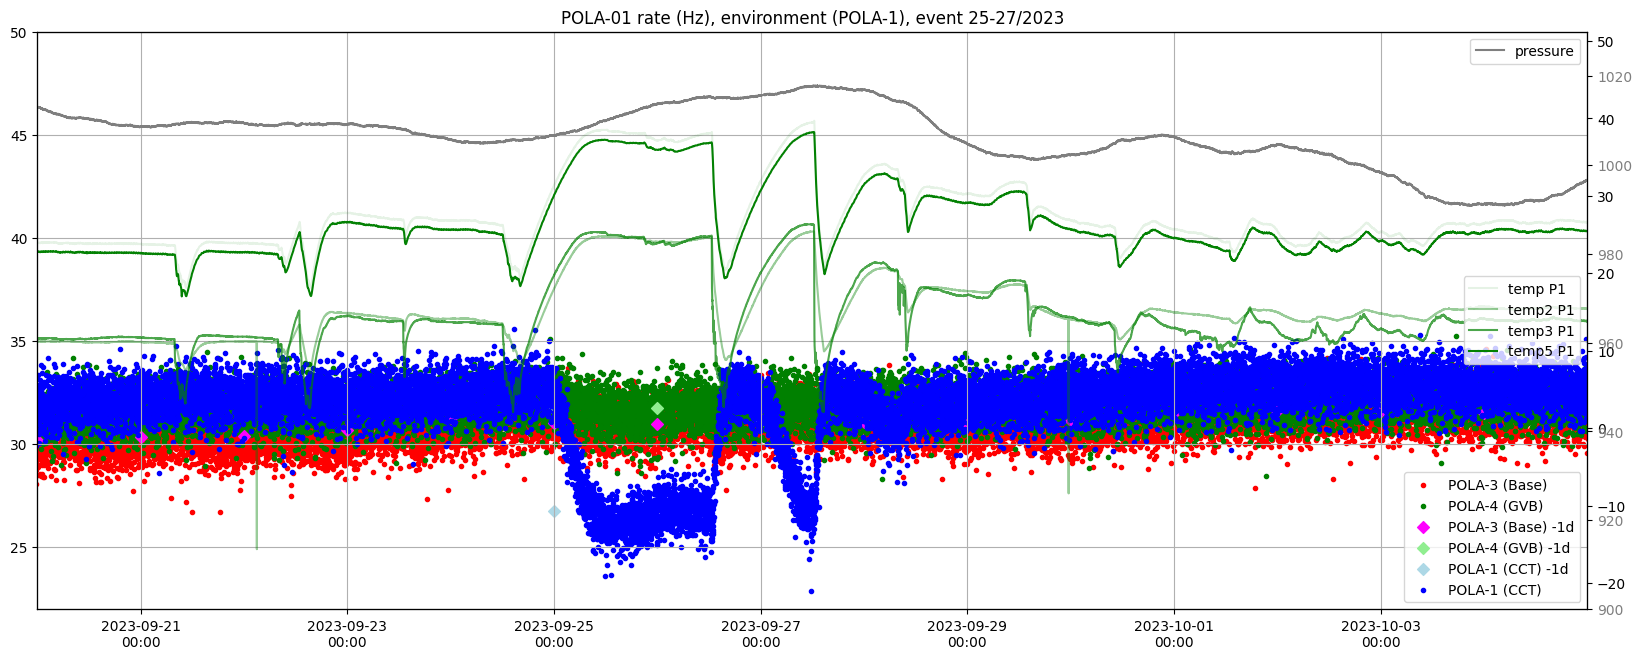

In [147]:
#------------- what happened on 25-26-27/9/2023 to POLA-1 -------------#
#
#  arrays already computed in the previous frame
#

plt.rcParams["figure.figsize"] = (20,7.5)
ax=plt.gca()
plt.title("POLA-01 rate (Hz), environment (POLA-1), event 25-27/2023")
#ax.set_ylim(27,36)  #--- OK if there is resampling
ax.set_ylim(22,50)

plt.scatter(to3,ro3,color='red',marker=".",label="POLA-3 (Base)")
plt.scatter(to4,ro4,color='green',marker='.',label="POLA-4 (GVB)")
plt.scatter(t3,r3,color='magenta',marker="D",label="POLA-3 (Base) -1d")
plt.scatter(t4,r4,color='lightgreen',marker='D',label="POLA-4 (GVB) -1d")
plt.scatter(t1,r1,color='lightblue',marker="D",label="POLA-1 (CCT) -1d")
plt.scatter(to1,ro1,color='blue',marker=".",label="POLA-1 (CCT)")
plt.grid(visible=True)
plt.legend(loc='lower right')
plt.xlim(datetime(2023,9,20,0,0),datetime(2023,10,4,23,59))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
ax.xaxis.set_major_formatter(xfmt)

ax2 = ax.twinx()
color4 = 'tab:green'
#ax2.set_ylabel('env', color=color)
ax2.plot(to1, temo1,  color=('green', 0.1), label="temp P1")
ax2.plot(to1, temo12, color=('green', 0.4), label="temp2 P1")
ax2.plot(to1, temo13, color=('green', 0.7), label="temp3 P1")
ax2.plot(to1, temo15, color=('green', 0.99), label="temp5 P1")
ax3.set_ylim(20,40)
plt.legend(loc='center right')

ax3 = ax.twinx()
color = 'tab:grey'
ax3.plot(to1, preo1, color=color, label='pressure')
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(900,1030)
plt.legend(loc='upper right')


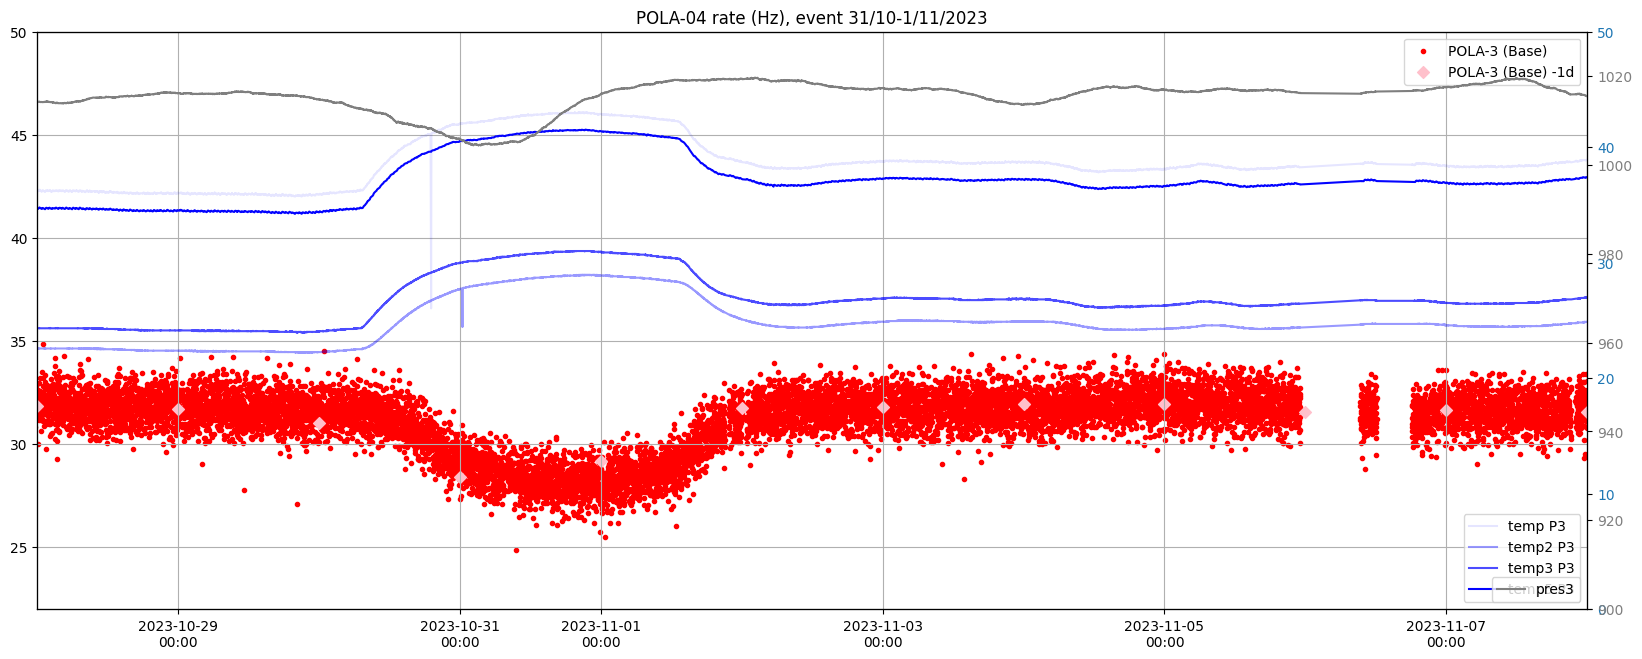

In [148]:
#------------- what happened to POLA-4 on 1/11/2023 -------------#


plt.rcParams["figure.figsize"] = (20,7.5)
ax=plt.gca()
plt.title("POLA-04 rate (Hz), event 31/10-1/11/2023")
#ax.set_ylim(27,36)  #--- OK if there is resampling
ax.set_ylim(22,50)

#plt.scatter(to1,ro1,color='blue',marker=".",label="POLA-1 (CCT)")
plt.scatter(to3,ro3,color='red',marker=".",label="POLA-3 (Base)")
#plt.scatter(to4,ro4,color='green',marker='.',label="POLA-4 (GVB)")
#plt.scatter(t1,r1,color='lightblue',marker="D",label="POLA-1 (CCT) -1d")
plt.scatter(t3,r3,color='pink',marker="D",label="POLA-3 (Base) -1d")
#plt.scatter(t4,r4,color='lightgreen',marker='D',label="POLA-4 (GVB) -1d")
plt.grid(visible=True)
plt.legend(loc='upper right')
plt.xlim(datetime(2023,10,28,0,0),datetime(2023,11,8,0,0))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
ax.xaxis.set_major_formatter(xfmt)


ax2 = ax.twinx()
color = 'tab:blue'
#ax2.set_ylabel('env', color=color)
ax2.plot(to3, temo3,  color=('blue', 0.1), label="temp P3")
ax2.plot(to3, temo32, color=('blue', 0.4), label="temp2 P3")
ax2.plot(to3, temo33, color=('blue', 0.7), label="temp3 P3")
ax2.plot(to3, temo35, color=('blue', 0.99), label="temp5 P3")
plt.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,50)
plt.legend(loc='lower right')
ax3 = ax.twinx()

color = 'tab:grey'
#ax3.set_ylabel('env', color=color)
ax3.plot(to3, preo3, color=color, label='pres3')
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(900,1030)
plt.legend(loc='lower right')



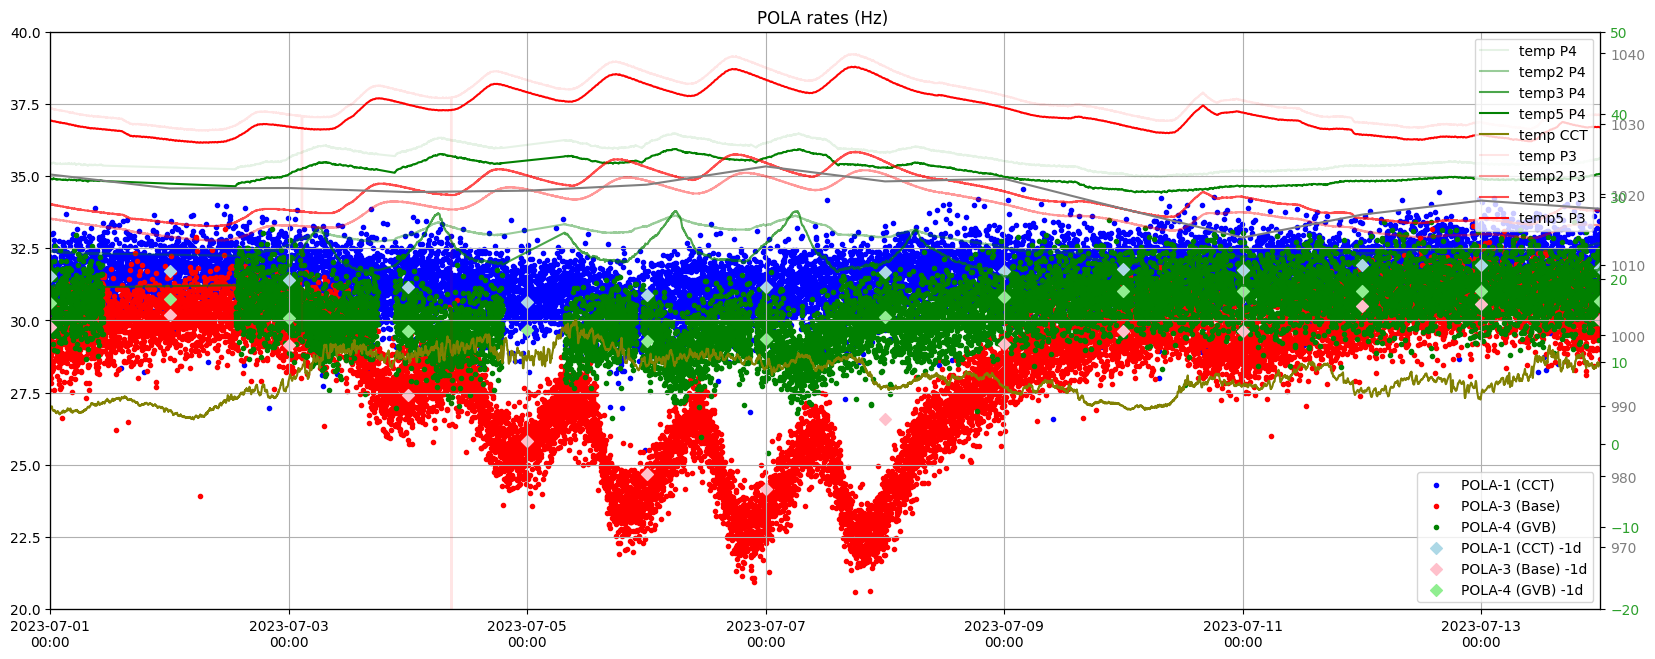

In [150]:
#--------- again the plot to check what happened in July 2023 ----------------#

plt.rcParams["figure.figsize"] = (20,7.5)
ax=plt.gca()
plt.title("POLA rates (Hz) ")
#ax.set_ylim(27,36)  #--- OK if there is resampling
ax.set_ylim(20,40)

plt.scatter(to1,ro1,color='blue',marker=".",label="POLA-1 (CCT)")
plt.scatter(to3,ro3,color='red',marker=".",label="POLA-3 (Base)")
plt.scatter(to4,ro4,color='green',marker='.',label="POLA-4 (GVB)")
plt.scatter(t1,r1,color='lightblue',marker="D",label="POLA-1 (CCT) -1d")
plt.scatter(t3,r3,color='pink',marker="D",label="POLA-3 (Base) -1d")
plt.scatter(t4,r4,color='lightgreen',marker='D',label="POLA-4 (GVB) -1d")
plt.grid(visible=True)
plt.legend(loc='lower right')
plt.xlim(datetime(2023,7,1,0,0),datetime(2023,7,13,23,59))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
ax.xaxis.set_major_formatter(xfmt)

ax2 = ax.twinx()
color4 = 'tab:green'
#ax2.set_ylabel('env', color=color)
ax2.plot(to4, temo4,  color=('green', 0.1), label="temp P4")
ax2.plot(to4, temo42, color=('green', 0.4), label="temp2 P4")
ax2.plot(to4, temo43, color=('green', 0.7), label="temp3 P4")
ax2.plot(to4, temo45, color=('green', 0.99), label="temp5 P4")
ax2.plot(time_CCT, temp_CCT, color=('olive', 0.99), label="temp CCT")
plt.legend(loc='upper right')

color3 = 'tab:red'
#ax2.set_ylabel('env', color=color)
ax2.plot(to3, temo3,  color=('red', 0.1), label="temp P3")
ax2.plot(to3, temo32, color=('red', 0.4), label="temp2 P3")
ax2.plot(to3, temo33, color=('red', 0.7), label="temp3 P3")
ax2.plot(to3, temo35, color=('red', 0.99), label="temp5 P3")
plt.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor=color4)
ax2.set_ylim(-20,50)
ax3 = ax.twinx()
color = 'tab:grey'
ax3.plot(t4, pres4, color=color)
ax3.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped



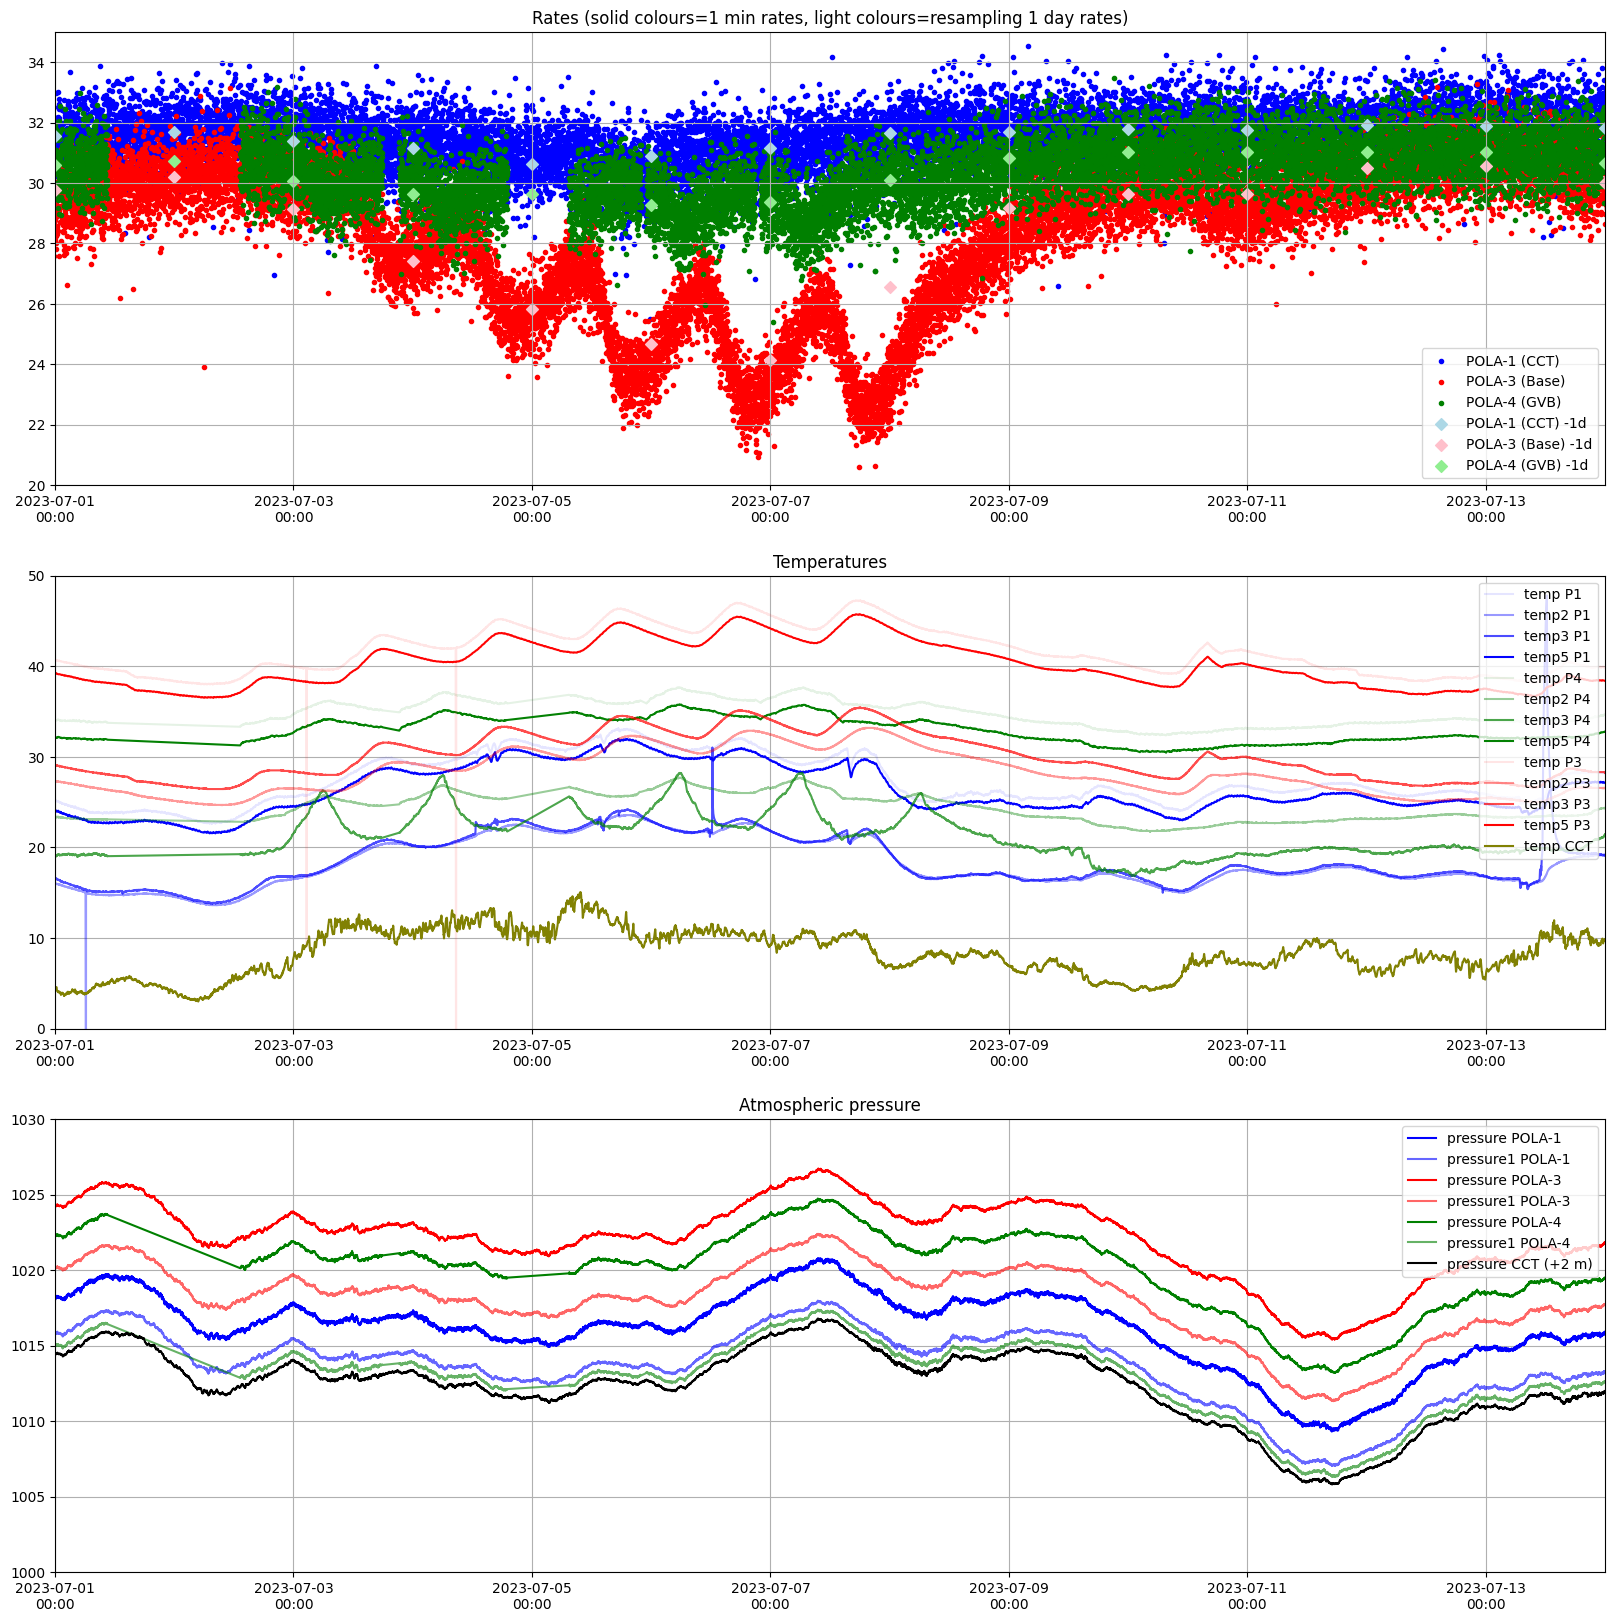

In [153]:
#-------------- July 2023: plot split in 3 subplots -----------------------#
plt.rcParams["figure.figsize"] = (20,20)
fig, axs = plt.subplots(3,1)
y0=20
y1=35
axs[0].set_title('Rates (solid colours=1 min rates, light colours=resampling 1 day rates)')
axs[0].scatter(to1,ro1,color='blue',marker=".",label="POLA-1 (CCT)")
axs[0].scatter(to3,ro3,color='red',marker=".",label="POLA-3 (Base)")
axs[0].scatter(to4,ro4,color='green',marker='.',label="POLA-4 (GVB)")
axs[0].scatter(t1,r1,color='lightblue',marker="D",label="POLA-1 (CCT) -1d")
axs[0].scatter(t3,r3,color='pink',marker="D",label="POLA-3 (Base) -1d")
axs[0].scatter(t4,r4,color='lightgreen',marker='D',label="POLA-4 (GVB) -1d")
axs[0].grid(visible=True)
axs[0].legend(loc='lower right')
axs[0].set(xlim=(datetime(2023,7,1,0,0),datetime(2023,7,13,23,59)),ylim=(y0,y1))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
axs[0].xaxis.set_major_formatter(xfmt)

axs[1].set_title('Temperatures')
color4 = 'tab:green'
axs[1].plot(to1, temo1,  color=('blue', 0.1), label="temp P1")
axs[1].plot(to1, temo12, color=('blue', 0.4), label="temp2 P1")
axs[1].plot(to1, temo13, color=('blue', 0.7), label="temp3 P1")
axs[1].plot(to1, temo15, color=('blue', 0.99), label="temp5 P1")
axs[1].plot(to4, temo4,  color=('green', 0.1), label="temp P4")
axs[1].plot(to4, temo42, color=('green', 0.4), label="temp2 P4")
axs[1].plot(to4, temo43, color=('green', 0.7), label="temp3 P4")
axs[1].plot(to4, temo45, color=('green', 0.99), label="temp5 P4")
axs[1].plot(to3, temo3,  color=('red', 0.1), label="temp P3")
axs[1].plot(to3, temo32, color=('red', 0.4), label="temp2 P3")
axs[1].plot(to3, temo33, color=('red', 0.7), label="temp3 P3")
axs[1].plot(to3, temo35, color=('red', 0.99), label="temp5 P3")
axs[1].plot(time_CCT, temp_CCT, color=('olive', 0.99), label="temp CCT")
axs[1].set(xlim=(datetime(2023,7,1,0,0),datetime(2023,7,13,23,59)),ylim=(0,50))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
axs[1].xaxis.set_major_formatter(xfmt)
axs[1].legend(loc='upper right')
axs[1].grid(visible=True)

axs[2].set_title('Atmospheric pressure')
axs[2].plot(to1, preo1, color='blue',label='pressure POLA-1')
axs[2].plot(to1, preo11, color=('blue',0.6),label='pressure1 POLA-1')
axs[2].plot(to3, preo3, color='red',label='pressure POLA-3')
axs[2].plot(to3, preo31, color=('red',0.6),label='pressure1 POLA-3')
axs[2].plot(to4, preo4, color='green',label='pressure POLA-4')
axs[2].plot(to4, preo41, color=('green',0.6),label='pressure1 POLA-4')
axs[2].plot(time_CCT, pres_CCT, color='black',label="pressure CCT (+2 m)")
axs[2].tick_params(axis='y', labelcolor='black')
axs[2].set(xlim=(datetime(2023,7,1,0,0),datetime(2023,7,13,23,59)),ylim=(1000,1030))
xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
axs[2].xaxis.set_major_formatter(xfmt)
axs[2].grid(visible=True)
axs[2].legend(loc='upper right')
